In [1]:
# quassian_quadrature.py
"""Volume 2: Gaussian Quadrature.
Nathan Schill
Section 2
Thurs. Feb. 2, 2023
"""

import numpy as np
from scipy import linalg as la
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt

In [23]:
class GaussianQuadrature:
    """Class for integrating functions on arbitrary intervals using Gaussian
    quadrature with the Legendre polynomials or the Chebyshev polynomials.
    """
    # Problems 1 and 3
    def __init__(self, n, polytype="legendre"):
        """Calculate and store the n points and weights corresponding to the
        specified class of orthogonal polynomial (Problem 3). Also store the
        inverse weight function w(x)^{-1} = 1 / w(x).

        Parameters:
            n (int): Number of points and weights to use in the quadrature.
            polytype (string): The class of orthogonal polynomials to use in
                the quadrature. Must be either 'legendre' or 'chebyshev'.

        Raises:
            ValueError: if polytype is not 'legendre' or 'chebyshev'.
        """

        # Define available classes and weight functions        
        poly_weight_fns = {'legendre' : lambda t: 1, 'chebyshev' : lambda t: 1/(1-t**2)**(1/2)}

        # Verify polytype is valid
        if polytype not in poly_weight_fns:
            raise ValueError('polytype should be either legendre or chebyshev')
        
        # Save n, polytype, w, and w^-1
        self.n = n
        self.polytype = polytype
        self.w = poly_weight_fns[polytype]
        self.inv_w = lambda t: 1/self.w(t)

        # Store points and weights
        self.points, self.weights = self.points_weights(n)
    

    # Problem 2
    def points_weights(self, n):
        """Calculate the n points and weights for Gaussian quadrature.

        Parameters:
            n (int): The number of desired points and weights.

        Returns:
            points ((n,) ndarray): The sampling points for the quadrature.
            weights ((n,) ndarray): The weights corresponding to the points.
        """
        
        # Define alpha and beta sequences and measure of the weight function
        if self.polytype == 'legendre':
            alpha = [0] * n
            beta = [k**2/(4*k**2 - 1) for k in range(1, n+1)]
            mu_w = 2
        elif self.polytype == 'chebyshev':
            alpha = [0] * n
            beta = [1/2] + [1/4] * (n - 1)
            mu_w = np.pi
        
        # Define J
        beta_diag = np.sqrt(beta[:-1])
        J = np.diag(alpha) + \
            np.diag(beta_diag, 1) + np.diag(beta_diag, -1)
        
        # Get eigenstuff and compute weights
        evals, evects = la.eigh(J)
        weights = mu_w * evects[0]**2
        
        return np.array(evals), np.array(weights)
    

    # Problem 3
    def basic(self, f):
        """Approximate the integral of a f on the interval [-1,1]."""

        # Use (10.1) to approximate the integral
        return sum([f(x)*self.inv_w(x)*w for x, w in zip(self.points, self.weights)])


    # Problem 4
    def integrate(self, f, a, b):
        """Approximate the integral of a function on the interval [a,b].

        Parameters:
            f (function): Callable function to integrate.
            a (float): Lower bound of integration.
            b (float): Upper bound of integration.

        Returns:
            (float): Approximate value of the integral.
        """
        
        # Define h as in the lab PDF and use (10.2) for the integral
        h = lambda t: f((b-a)/2 * t + (a+b)/2)
        return (b-a)/2 * self.basic(h)


    # Problem 6.
    def integrate2d(self, f, a1, b1, a2, b2):
        """Approximate the integral of the two-dimensional function f on
        the interval [a1,b1]x[a2,b2].

        Parameters:
            f (function): A function to integrate that takes two parameters.
            a1 (float): Lower bound of integration in the x-dimension.
            b1 (float): Upper bound of integration in the x-dimension.
            a2 (float): Lower bound of integration in the y-dimension.
            b2 (float): Upper bound of integration in the y-dimension.

        Returns:
            (float): Approximate value of the integral.
        """
        
        # Define h and g
        h = lambda x, y: f(
            (b1-a1)/2 * x + (a1+b1)/2,
            (b2-a2)/2 * y + (a2+b2)/2
        )
        g = lambda x, y: h(x,y) * self.inv_w(x) * self.inv_w(y)

        # Use (10.5) to approximate the integral
        return (b1-a1)*(b2-a2)/4 *\
            np.sum([self.weights[i] * self.weights[j] * g(self.points[i], self.points[j])
                    for i in range(self.n) for j in range(self.n)])

gauss = GaussianQuadrature(10, 'legendre')

# f = lambda t: 1 / np.sqrt(1 - t**2)
# gauss.basic(f), gauss.integrate(f, -1, 1)

# Integrate f(x,y) = sin(x) + cos(y) over [-10,10] in x and [-1,1] in y.
# a1, b1, a2, b2 = -10, 10, -1, 1
# g = lambda x, y: np.sin(x) + np.cos(y)

# a1, b1, a2, b2 = -1, 2, -3, 4
# g = lambda x, y: x**2 * y**2
# gauss = GaussianQuadrature(30, 'legendre')
# gauss = GaussianQuadrature(30, 'chebyshev')

a1, b1, a2, b2 = -5, 6, -7, 8
g = lambda x, y: np.sin(x) * np.cos(y)
gauss = GaussianQuadrature(30, 'legendre')
gauss = GaussianQuadrature(30, 'chebyshev')

gauss.integrate2d(g, a1, b1, a2, b2), integrate.nquad(g, ((a1,b1), (a2,b2)))[0]


(-1.1123184595391025, -1.1137656252216677)

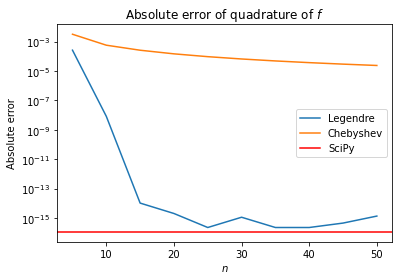

In [3]:
# Problem 5
def prob5():
   """Use scipy.stats to calculate the "exact" value F of the integral of
   f(x) = (1/sqrt(2 pi))e^((-x^2)/2) from -3 to 2. Then repeat the following
   experiment for n = 5, 10, 15, ..., 50.
      1. Use the GaussianQuadrature class with the Legendre polynomials to
         approximate F using n points and weights. Calculate and record the
         error of the approximation.
      2. Use the GaussianQuadrature class with the Chebyshev polynomials to
         approximate F using n points and weights. Calculate and record the
         error of the approximation.
   Plot the errors against the number of points and weights n, using a log
   scale for the y-axis. Finally, plot a horizontal line showing the error of
   scipy.integrate.quad() (which doesn’t depend on n).
   """
   
   # Define f, bounds
   f = lambda t: 1/(2*np.pi)**(1/2) * np.exp(-t**2 / 2)
   a, b = -3, 2

   # Get exact value of integral and estimate using SciPy's integrate.quad
   F = stats.norm.cdf(b) - stats.norm.cdf(a)
   F_est = integrate.quad(f, a, b)[0]

   # Get n-values
   N = range(5, 51, 5)

   # Store absolute errors
   lege_err = [None] * len(N)
   cheb_err = [None] * len(N)

   # Compute absolute errors
   for i, n in enumerate(N):
      # Legendre absolute error with n points and weights
      gauss_lege = GaussianQuadrature(n, 'legendre')
      lege_err[i] = abs(F - gauss_lege.integrate(f, a, b))

      # Chebyshev absolute error with n points and weights
      gauss_cheb = GaussianQuadrature(n, 'chebyshev')
      cheb_err[i] = abs(F - gauss_cheb.integrate(f, a, b))

   # Plot
   plt.plot(N, lege_err, label='Legendre')
   plt.plot(N, cheb_err, label='Chebyshev')
   plt.axhline(abs(F - F_est), label='SciPy', color='r')
   
   # Axes
   plt.xlabel('$n$')
   plt.ylabel('Absolute error')
   plt.yscale('log')

   # Properties
   plt.legend()
   plt.title('Absolute error of quadrature of $f$')
   plt.show()
   
prob5()
